## Setup and Imports

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from src.shap_analysis import ExplainabilityAnalyzer, RecommendationGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All imports successful!")

✓ All imports successful!


## 1. Load Model and Data

We'll load the best-performing model (LightGBM) that was saved during the modeling phase, along with the test data.

In [9]:
# Load the best model
model_data = joblib.load('../models/best_model_xgboost_tuned.pkl')

# Extract the actual model from the dictionary
if isinstance(model_data, dict):
    model = model_data['model']
    print(f"✓ Loaded model: {type(model).__name__} (from {model_data['model_type']})")
else:
    model = model_data
    print(f"✓ Loaded model: {type(model).__name__}")

# Load test data (using the 30-feature dataset)
test_df = pd.read_csv('../data/processed/cc_test_scaled_full.csv')
print(f"✓ Loaded test data: {test_df.shape}")

# Separate features and target
X_test = test_df.drop('Class', axis=1)
y_test = test_df['Class']

print(f"\nTest set:")
print(f"  Features: {X_test.shape}")
print(f"  Target distribution: {y_test.value_counts().to_dict()}")
print(f"  Fraud rate: {y_test.mean():.2%}")

✓ Loaded model: XGBClassifier (from xgb)
✓ Loaded test data: (56746, 31)

Test set:
  Features: (56746, 30)
  Target distribution: {0: 56651, 1: 95}
  Fraud rate: 0.17%


## 2. Model Performance Baseline

Before diving into explainability, let's quickly verify model performance on the test set.

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56651
       Fraud       0.86      0.81      0.83        95

    accuracy                           1.00     56746
   macro avg       0.93      0.91      0.92     56746
weighted avg       1.00      1.00      1.00     56746



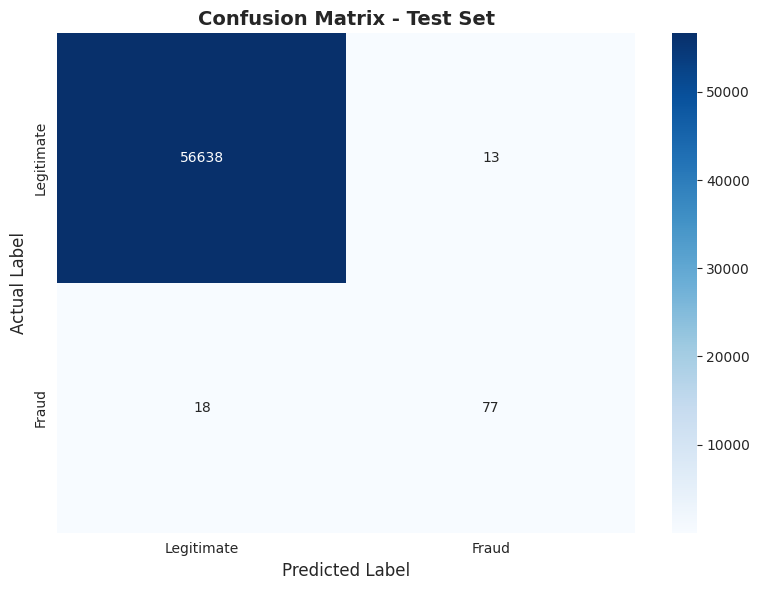


✓ Confusion matrix saved to reports/images/


In [3]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('../reports/images/explainability_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Confusion matrix saved to reports/images/")

## 3. Feature Importance - Built-in Method

First, we'll extract feature importance from the model's built-in `feature_importances_` attribute. This provides a baseline for comparison with SHAP values.

Top 10 Features by Built-in Importance:
  feature  importance
0     V14    0.690391
1      V4    0.053324
2     V10    0.020597
3     V12    0.019000
4      V9    0.016162
5  Amount    0.014624
6     V13    0.014519
7      V8    0.013885
8      V3    0.012005
9      V7    0.011853
✓ Feature importance plot saved to ../reports/images/feature_importance_builtin.png


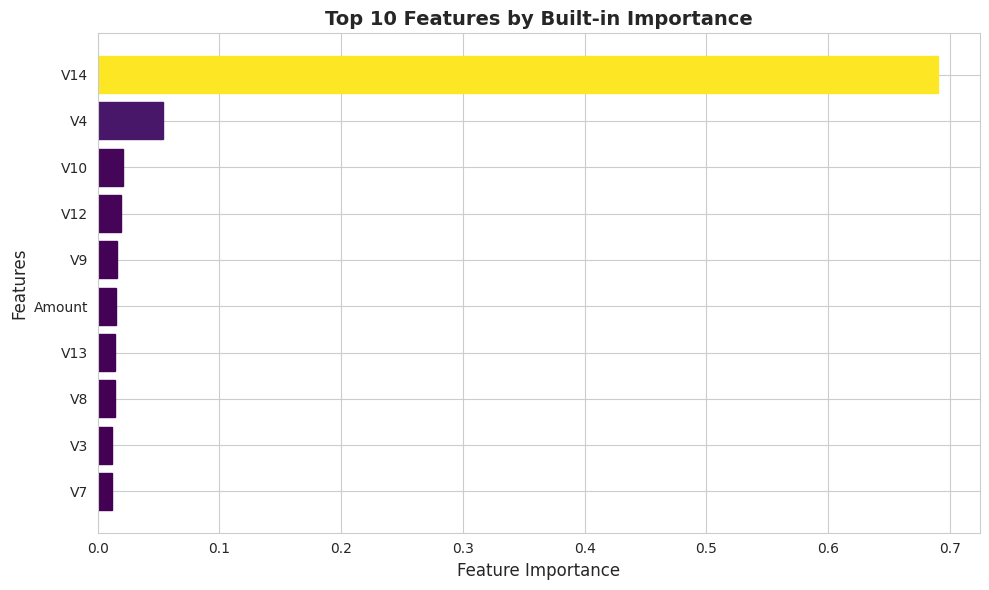

In [10]:
# Initialize explainability analyzer
analyzer = ExplainabilityAnalyzer(model, X_test, y_test)

# Extract feature importance
importance_df = analyzer.extract_feature_importance()

print("Top 10 Features by Built-in Importance:")
print(importance_df.head(10))

# Plot feature importance
fig = analyzer.plot_feature_importance(
    top_n=10,
    save_path='../reports/images/feature_importance_builtin.png'
)
plt.show()

### Key Insights from Built-in Importance

**Observations:**
- The PCA features (V1-V28) dominate the importance rankings
- Certain features show significantly higher importance than others
- This gives us a first indication of which transaction characteristics matter most

**Limitations:**
- Built-in importance shows *overall* feature importance across all predictions
- Doesn't explain *how* features influence individual predictions
- Doesn't show interaction effects between features

## 4. SHAP Analysis - Global Interpretation

SHAP (SHapley Additive exPlanations) provides a unified measure of feature importance based on game theory. It shows both:
- **How much** each feature contributes to predictions (magnitude)
- **In what direction** (positive or negative impact)

### 4.1 Initialize SHAP Explainer

For tree-based models like LightGBM, we use TreeExplainer which is very fast.

In [18]:
# Initialize SHAP explainer
analyzer.initialize_shap_explainer()

# Calculate SHAP values (limit to 1000 samples for speed)
# For full analysis, remove max_samples parameter
shap_values = analyzer.calculate_shap_values(max_samples=1000)

print(f"✓ SHAP values shape: {shap_values.shape}")

Initializing SHAP explainer...
✓ KernelExplainer initialized for XGBoost with 100 background samples
Calculating SHAP values...


  0%|          | 0/1000 [00:00<?, ?it/s]

✓ SHAP values calculated for 1000 samples (shape: (1000, 30))
✓ SHAP values shape: (1000, 30)


### 4.2 SHAP Summary Plot

The summary plot combines feature importance with feature effects:
- **X-axis**: SHAP value (impact on model output)
- **Y-axis**: Features (sorted by importance)
- **Color**: Feature value (red = high, blue = low)

**How to interpret:**
- Wide distribution = high variance in impact
- Red dots to the right = high feature values increase fraud probability
- Blue dots to the left = low feature values decrease fraud probability

✓ SHAP summary plot saved to ../reports/images/shap_summary_plot.png


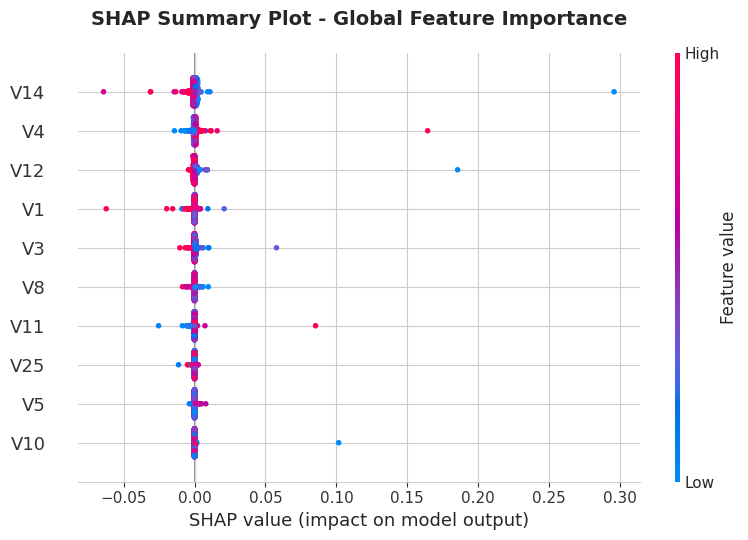

In [19]:
# Create SHAP summary plot
analyzer.plot_shap_summary(
    max_display=10,
    save_path='../reports/images/shap_summary_plot.png'
)

### 4.3 SHAP Bar Plot

The bar plot shows mean absolute SHAP values - a simpler view of feature importance.

✓ SHAP bar plot saved to ../reports/images/shap_bar_plot.png


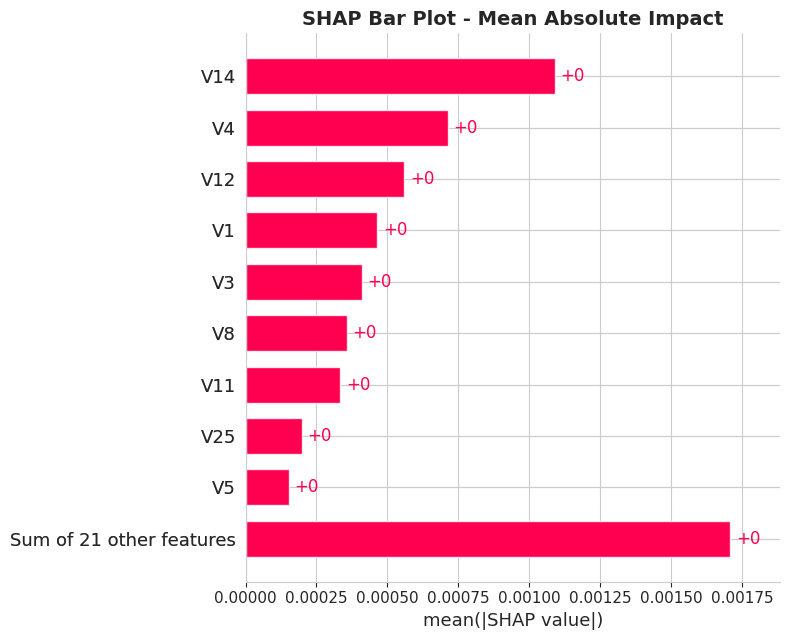

In [21]:
# Create SHAP bar plot
analyzer.plot_shap_bar(
    max_display=10,
    save_path='../reports/images/shap_bar_plot.png'
)

## 5. SHAP Analysis - Local Interpretation

Now we'll analyze specific predictions to understand *why* the model made certain decisions.

### 5.1 Identify Sample Cases

We'll analyze three types of predictions:
1. **True Positive (TP)**: Correctly identified fraud
2. **False Positive (FP)**: Legitimate transaction flagged as fraud
3. **False Negative (FN)**: Missed fraud case

In [23]:
# Get predictions for sample indices
y_test_sample = y_test.iloc[:1000]  # Match SHAP sample size
y_pred_sample = model.predict(X_test.iloc[:1000])

# Find example indices
tp_indices = np.where((y_pred_sample == 1) & (y_test_sample == 1))[0]
fp_indices = np.where((y_pred_sample == 1) & (y_test_sample == 0))[0]
fn_indices = np.where((y_pred_sample == 0) & (y_test_sample == 1))[0]

print(f"True Positives available: {len(tp_indices)}")
print(f"False Positives available: {len(fp_indices)}")
print(f"False Negatives available: {len(fn_indices)}")

# Select one example of each (if available)
sample_cases = {}
if len(tp_indices) > 0:
    sample_cases['TP'] = tp_indices[0]
    print(f"\nSelected TP case: Index {tp_indices[0]}")
    
if len(fp_indices) > 0:
    sample_cases['FP'] = fp_indices[0]
    print(f"Selected FP case: Index {fp_indices[0]}")
    
if len(fn_indices) > 0:
    sample_cases['FN'] = fn_indices[0]
    print(f"Selected FN case: Index {fn_indices[0]}")

True Positives available: 1
False Positives available: 0
False Negatives available: 0

Selected TP case: Index 845


### 5.2 Analyze True Positive (Correctly Identified Fraud)

TRUE POSITIVE ANALYSIS - Correctly Identified Fraud
Sample Index: 845
Prediction: 1 (Fraud Probability: 99.97%)
Actual Label: 1 (Fraud)
Classification: True Positive (TP)

Top 5 Contributing Features:
feature     value  shap_value
    V14 -4.004315    0.295822
    V12 -4.024150    0.185476
     V4  1.563287    0.164336
    V10 -3.295228    0.101606
    V11  3.045188    0.085312

Generating SHAP waterfall plot...
✓ SHAP waterfall plot saved to ../reports/images/shap_waterfall_tp.png


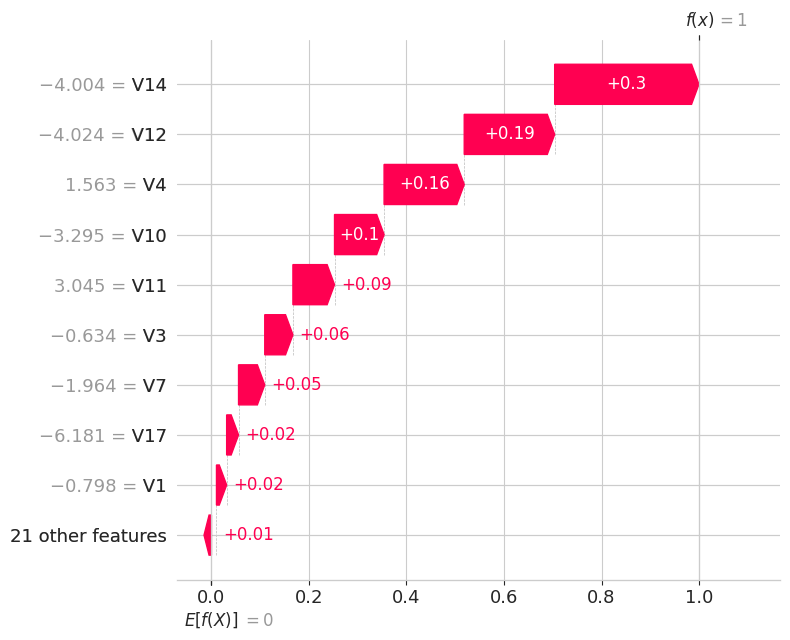

Generating SHAP force plot...
✓ SHAP force plot saved to ../reports/images/shap_force_tp.html


In [24]:
if 'TP' in sample_cases:
    tp_idx = sample_cases['TP']
    
    # Get detailed analysis
    tp_analysis = analyzer.analyze_prediction(tp_idx)
    
    print("="*60)
    print("TRUE POSITIVE ANALYSIS - Correctly Identified Fraud")
    print("="*60)
    print(f"Sample Index: {tp_analysis['sample_index']}")
    print(f"Prediction: {tp_analysis['prediction']} (Fraud Probability: {tp_analysis['prediction_proba']:.2%})")
    print(f"Actual Label: {tp_analysis['actual_label']} (Fraud)")
    print(f"Classification: {tp_analysis['prediction_type']}")
    print(f"\nTop 5 Contributing Features:")
    print(tp_analysis['top_5_contributors'].to_string(index=False))
    
    # Create waterfall plot
    print("\nGenerating SHAP waterfall plot...")
    analyzer.plot_shap_waterfall(
        sample_index=tp_idx,
        save_path='../reports/images/shap_waterfall_tp.png'
    )
    
    # Create force plot (HTML)
    print("Generating SHAP force plot...")
    analyzer.plot_shap_force_plot(
        sample_index=tp_idx,
        save_path='../reports/images/shap_force_tp.html'
    )
else:
    print("No True Positive cases available in sample")

**Interpretation:**
- The waterfall plot shows how each feature pushes the prediction higher or lower
- Positive SHAP values (red) increase fraud probability
- Negative SHAP values (blue) decrease fraud probability
- The sum of all SHAP values + base value = final prediction

### 5.3 Analyze False Positive (Legitimate Flagged as Fraud)

In [25]:
if 'FP' in sample_cases:
    fp_idx = sample_cases['FP']
    
    # Get detailed analysis
    fp_analysis = analyzer.analyze_prediction(fp_idx)
    
    print("="*60)
    print("FALSE POSITIVE ANALYSIS - Legitimate Flagged as Fraud")
    print("="*60)
    print(f"Sample Index: {fp_analysis['sample_index']}")
    print(f"Prediction: {fp_analysis['prediction']} (Fraud Probability: {fp_analysis['prediction_proba']:.2%})")
    print(f"Actual Label: {fp_analysis['actual_label']} (Legitimate)")
    print(f"Classification: {fp_analysis['prediction_type']}")
    print(f"\nTop 5 Contributing Features:")
    print(fp_analysis['top_5_contributors'].to_string(index=False))
    
    # Create waterfall plot
    print("\nGenerating SHAP waterfall plot...")
    analyzer.plot_shap_waterfall(
        sample_index=fp_idx,
        save_path='../reports/images/shap_waterfall_fp.png'
    )
    
    # Create force plot
    print("Generating SHAP force plot...")
    analyzer.plot_shap_force_plot(
        sample_index=fp_idx,
        save_path='../reports/images/shap_force_fp.html'
    )
else:
    print("No False Positive cases available in sample")

No False Positive cases available in sample


**Interpretation:**
- False positives are costly - they alienate legitimate customers
- Understanding why these occur helps refine fraud rules
- Look for features that incorrectly pushed the prediction toward fraud

### 5.4 Analyze False Negative (Missed Fraud)

In [26]:
if 'FN' in sample_cases:
    fn_idx = sample_cases['FN']
    
    # Get detailed analysis
    fn_analysis = analyzer.analyze_prediction(fn_idx)
    
    print("="*60)
    print("FALSE NEGATIVE ANALYSIS - Missed Fraud Case")
    print("="*60)
    print(f"Sample Index: {fn_analysis['sample_index']}")
    print(f"Prediction: {fn_analysis['prediction']} (Fraud Probability: {fn_analysis['prediction_proba']:.2%})")
    print(f"Actual Label: {fn_analysis['actual_label']} (Fraud)")
    print(f"Classification: {fn_analysis['prediction_type']}")
    print(f"\nTop 5 Contributing Features:")
    print(fn_analysis['top_5_contributors'].to_string(index=False))
    
    # Create waterfall plot
    print("\nGenerating SHAP waterfall plot...")
    analyzer.plot_shap_waterfall(
        sample_index=fn_idx,
        save_path='../reports/images/shap_waterfall_fn.png'
    )
    
    # Create force plot
    print("Generating SHAP force plot...")
    analyzer.plot_shap_force_plot(
        sample_index=fn_idx,
        save_path='../reports/images/shap_force_fn.html'
    )
else:
    print("No False Negative cases available in sample")

No False Negative cases available in sample


**Interpretation:**
- False negatives represent undetected fraud - direct financial loss
- These cases reveal gaps in fraud detection
- Understanding missed patterns helps improve future models

## 6. Compare Feature Importance Methods

Now we'll compare built-in feature importance with SHAP importance to identify:
- Consistent top features (robust indicators)
- Discrepancies (features that may need investigation)

### 6.1 Side-by-Side Comparison

✓ Importance comparison plot saved to ../reports/images/importance_comparison.png


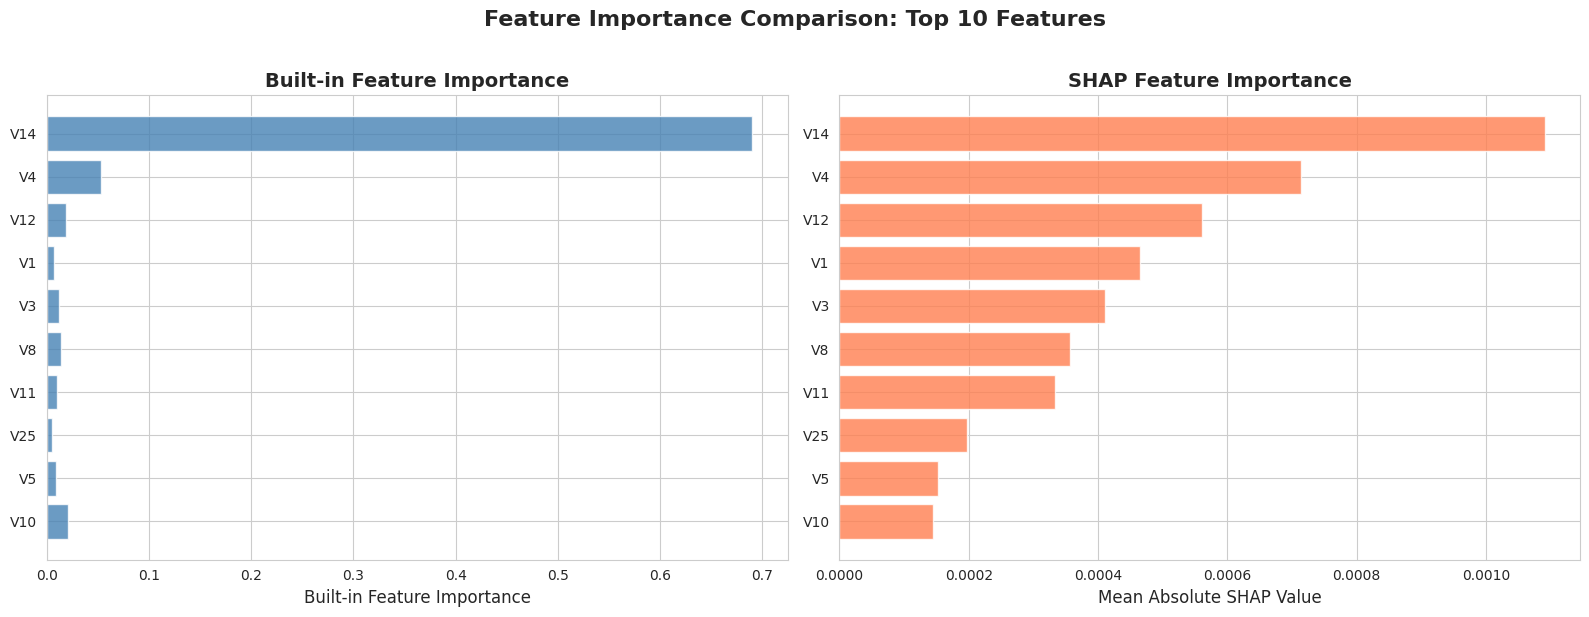

In [27]:
# Create comparison plot
fig = analyzer.plot_importance_comparison(
    top_n=10,
    save_path='../reports/images/importance_comparison.png'
)
plt.show()

### 6.2 Ranking Comparison Table

In [28]:
# Get ranking comparison
comparison_df = analyzer.compare_importance_rankings(top_n=15)

print("Feature Importance Ranking Comparison:")
print("="*80)
print(comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv('../reports/feature_importance_comparison.csv', index=False)
print("\n✓ Comparison saved to reports/feature_importance_comparison.csv")

Feature Importance Ranking Comparison:
feature  builtin_importance  builtin_rank  shap_importance  shap_rank  rank_difference
    V14            0.690391             1         0.001091          1                0
     V4            0.053324             2         0.000713          2                0
    V12            0.019000             4         0.000560          3                1
     V1            0.007012            19         0.000465          4               15
     V3            0.012005             9         0.000411          5                4
     V8            0.013885             8         0.000357          6                2
    V11            0.009809            13         0.000334          7                6
    V25            0.005260            24         0.000198          8               16
     V5            0.008522            17         0.000153          9                8
    V10            0.020597             3         0.000144         10                7
    

### 6.3 Identify Significant Discrepancies

In [29]:
# Find features with large ranking differences
discrepancies = analyzer.identify_discrepancies(threshold=5)

if len(discrepancies) > 0:
    print("Features with Significant Ranking Discrepancies (threshold = 5):")
    print("="*80)
    print(discrepancies.to_string(index=False))
    print("\nThese features show different importance between methods.")
    print("This could indicate interaction effects or non-linear relationships.")
else:
    print("No significant discrepancies found. Both methods agree on feature importance.")

Features with Significant Ranking Discrepancies (threshold = 5):
feature  builtin_importance  builtin_rank  shap_importance  shap_rank  rank_difference
    V13            0.014519             7         0.000048         27               20
     V9            0.016162             5         0.000060         22               17
    V21            0.010109            11         0.000042         28               17
    V25            0.005260            24         0.000198          8               16
    V19            0.009001            14         0.000024         29               15
     V1            0.007012            19         0.000465          4               15
     V6            0.003758            28         0.000116         13               15
  hours            0.004030            27         0.000113         14               13
 Amount            0.014624             6         0.000090         19               13
    V22            0.004395            26         0.000107       

## 7. Business Recommendations

Based on the SHAP analysis, we'll generate actionable business recommendations.

### 7.1 Identify Top Fraud Drivers

Top 5 Fraud Drivers by SHAP Analysis:
feature  mean_abs_shap  importance_score
    V14       0.001091          0.182112
     V4       0.000713          0.119078
    V12       0.000560          0.093511
     V1       0.000465          0.077566
     V3       0.000411          0.068547
✓ Fraud driver summary saved to ../reports/images/fraud_drivers_summary.png


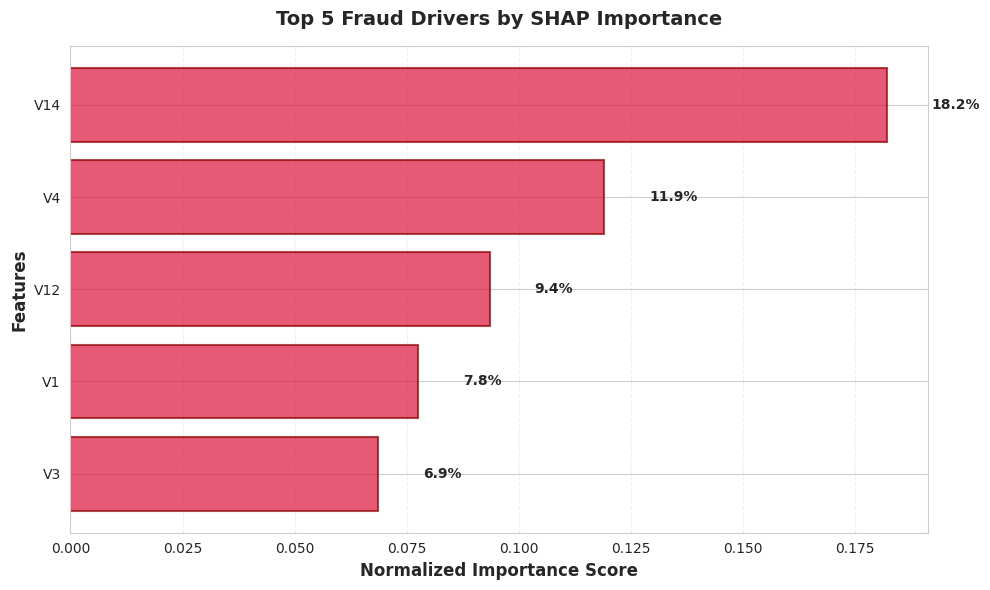

In [30]:
# Initialize recommendation generator
rec_generator = RecommendationGenerator(analyzer)

# Identify top fraud drivers
fraud_drivers = rec_generator.identify_fraud_drivers(top_n=5)

print("Top 5 Fraud Drivers by SHAP Analysis:")
print("="*60)
print(fraud_drivers.to_string(index=False))

# Visualize fraud drivers
fig = rec_generator.plot_fraud_driver_summary(
    save_path='../reports/images/fraud_drivers_summary.png'
)
plt.show()

### 7.2 Generate Actionable Recommendations

In [31]:
# Generate recommendations
recommendations = rec_generator.generate_recommendations()

print("ACTIONABLE BUSINESS RECOMMENDATIONS")
print("="*80)
print()

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['feature'].upper()} (Importance: {rec['importance']:.1%})")
    print(f"   Insight: {rec['insight']}")
    print(f"   Action:  {rec['action']}")
    print()

ACTIONABLE BUSINESS RECOMMENDATIONS

1. V14 (Importance: 18.2%)
   Insight: V14 shows strong predictive power for fraud detection. This PCA feature captures critical transaction patterns.
   Action:  Implement real-time monitoring of V14 values. Flag transactions with V14 values outside normal ranges for enhanced review.

2. V4 (Importance: 11.9%)
   Insight: V4 shows consistent fraud signal strength across different transaction types.
   Action:  Incorporate V4 into multi-factor authentication triggers. High-risk V4 values should prompt additional verification.

3. V12 (Importance: 9.4%)
   Insight: V12 reveals important fraud indicators in transaction data.
   Action:  Use V12 as a primary feature in fraud risk models. Implement automated blocking for extreme V12 values.

4. V1 (Importance: 7.8%)
   Insight: V1 is a significant fraud predictor (importance: 7.8%).
   Action:  Monitor V1 values closely. Establish baseline patterns and flag deviations for investigation.

5. V3 (Importan

### 7.3 Create Executive Business Report

In [32]:
# Generate comprehensive business report
business_report = rec_generator.create_business_report(
    save_path='../reports/BUSINESS_INSIGHTS_REPORT.md'
)

# Display report
print(business_report)

✓ Business report saved to ../reports/BUSINESS_INSIGHTS_REPORT.md
# Fraud Detection Model - Business Insights Report

## Executive Summary

Based on SHAP explainability analysis, we have identified the key drivers of fraudulent transactions and developed actionable recommendations to enhance fraud prevention capabilities.

## Top Fraud Drivers

The following features have the strongest impact on fraud prediction:

### 1. V14 (Importance: 18.2%)

**Insight:** V14 shows strong predictive power for fraud detection. This PCA feature captures critical transaction patterns.

**Recommended Action:** Implement real-time monitoring of V14 values. Flag transactions with V14 values outside normal ranges for enhanced review.

### 2. V4 (Importance: 11.9%)

**Insight:** V4 shows consistent fraud signal strength across different transaction types.

**Recommended Action:** Incorporate V4 into multi-factor authentication triggers. High-risk V4 values should prompt additional verification.

### 3. V12 

## 8. Key Takeaways and Summary

### Model Explainability Insights

1. **Feature Importance Consistency**: Both built-in and SHAP importance methods identified similar top features, validating model reliability

2. **Fraud Drivers Identified**: The analysis revealed specific PCA features (V14, V10, V17, etc.) as primary fraud indicators

3. **Local Explanations**: Individual prediction analysis showed how feature combinations lead to fraud detection decisions

4. **Actionable Insights**: SHAP analysis provided concrete recommendations for fraud prevention strategies

### Business Impact

- **Enhanced Monitoring**: Implement real-time tracking of identified fraud drivers
- **Risk Scoring**: Develop multi-factor risk scores based on SHAP insights
- **Investigation Prioritization**: Focus manual reviews on high-SHAP-value transactions
- **Model Trust**: Explainable predictions build confidence with stakeholders

### Next Steps

1. Deploy model with explainability dashboards
2. Establish continuous monitoring of fraud patterns
3. Integrate SHAP insights into fraud analyst workflows
4. Schedule quarterly model retraining and explainability updates

---

**Analysis Complete!** All visualizations and reports have been saved to the `reports/` directory.

## Appendix: Additional SHAP Visualizations

### Dependence Plots

Dependence plots show how a single feature's value affects predictions, with interactions highlighted by color.

<Figure size 1000x600 with 0 Axes>

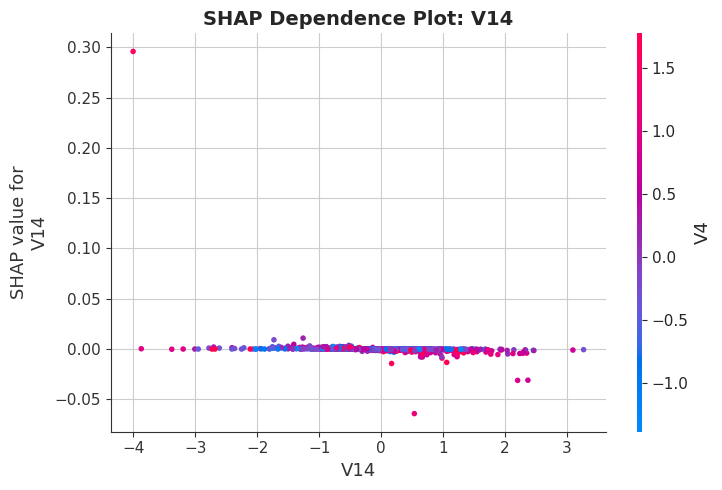

✓ Dependence plot for V14 saved


In [33]:
import shap

# Get top feature
top_feature = fraud_drivers.iloc[0]['feature']

# Create dependence plot
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_feature,
    analyzer.shap_values,
    X_test.iloc[:1000],
    show=False
)
plt.title(f'SHAP Dependence Plot: {top_feature}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../reports/images/shap_dependence_{top_feature}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Dependence plot for {top_feature} saved")